# 1. Packages

In [24]:
import pandas as pd
import pyarrow
import fastparquet
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from joblib import Parallel, delayed
from sklearn.metrics import classification_report, accuracy_score, precision_score
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# 2. Data

In [6]:
os.chdir('/Users/clemenspaulsen/Desktop/May24_BDS_INT_Fire_Brigade/data')
df = pd.read_parquet('df_cleaned_for_classification_models.parquet')

target = df['ResponseTimeBinary']
features = df.drop(columns=['ResponseTimeBinary'])

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=666)

# 3. Boosting

In [8]:
# Perform PCA to achieve 85% explanation of the variation
pca = PCA(n_components=0.85)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [10]:
# Perform random under-sampling
rus = RandomUnderSampler(random_state=666)
X_train_res, y_train_res = rus.fit_resample(X_train_pca, y_train)

In [46]:
# Define the AdaBoost classifier with DecisionTreeClassifier as the weak learner
weak_classifier = DecisionTreeClassifier(max_depth=1)
ada_boost = AdaBoostClassifier(base_estimator=weak_classifier, n_estimators=50, random_state=666)

In [48]:
# Train the AdaBoost model
ada_boost.fit(X_train_res, y_train_res)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   random_state=666)

In [50]:
# Predict and evaluate the model
y_pred = ada_boost.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

Accuracy: 0.6876
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.62      0.54     90243
           1       0.82      0.71      0.76    217298

    accuracy                           0.69    307541
   macro avg       0.65      0.67      0.65    307541
weighted avg       0.72      0.69      0.70    307541

ROC AUC Score: 0.7268


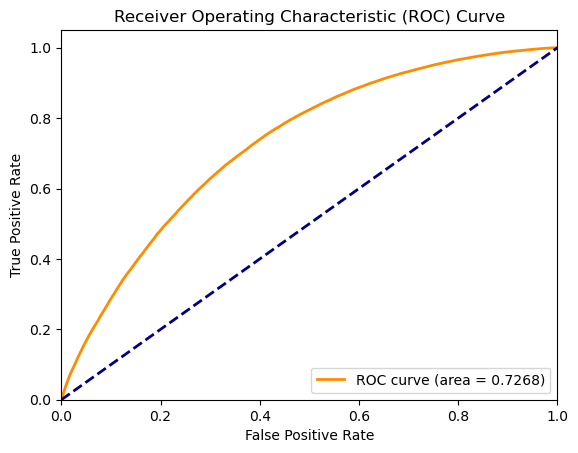

In [52]:
# Calculate ROC AUC score and plot the ROC curve
y_pred_proba = ada_boost.predict_proba(X_test_pca)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)
print(f'ROC AUC Score: {roc_auc:.4f}')

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()